# Load data & preprocess

In [136]:
genes.bc <- read.table(file = "../../data/pbmc/atac_genes_bc.bed", sep = "\t", as.is = c(4,7), header = FALSE)
promoters.bc <- read.table(file = "../../data/pbmc/atac_promoters_bc.bed", sep = "\t", as.is = c(4,7), header = FALSE)

In [3]:
bc <- genes.bc[,7]
bc_split <- strsplit(bc,";")
bc_split_vec <- unlist(bc_split)
bc_unique <- unique(bc_split_vec)
bc_counts <- table(bc_split_vec)

In [30]:
length(bc_unique)

[1] 563865

In [25]:
bc.counts.df = data.frame(bc_counts)
bc.counts.df$label = "read_count"

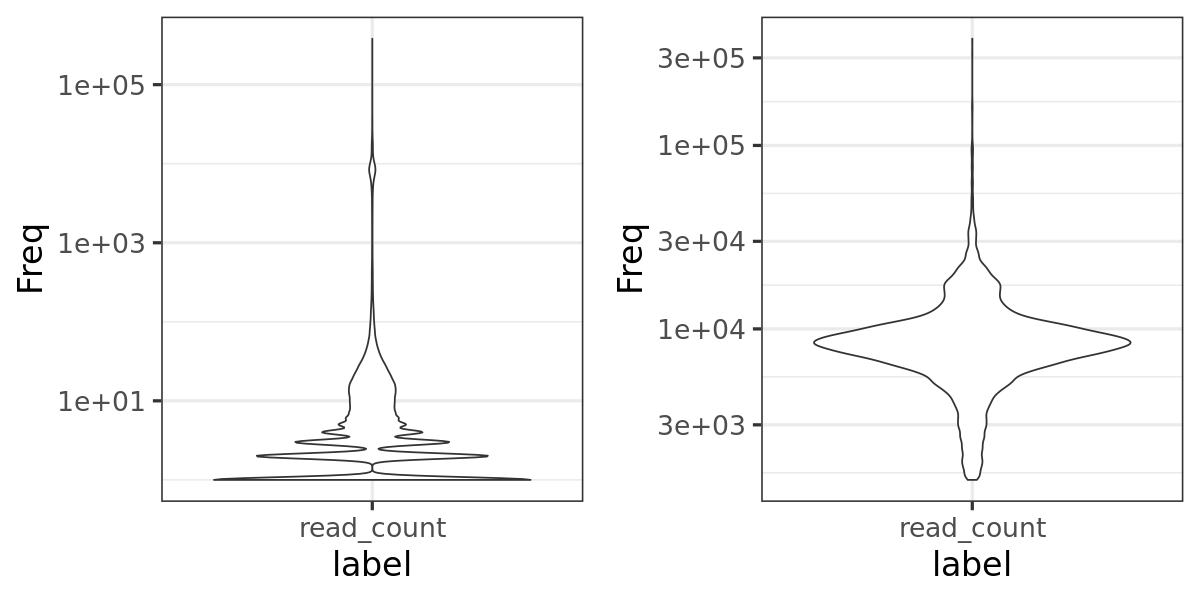

In [26]:
options(repr.plot.width = 10, repr.plot.height = 5)
library(ggplot2)
p1 <- ggplot(bc.counts.df, aes(x = label, y = Freq)) + geom_violin() + scale_y_log10() + theme_bw(base_size = 20)
p2 <- ggplot(subset(bc.counts.df, Freq > 1500), aes(x = label, y = Freq)) + geom_violin() + scale_y_log10()+ theme_bw(base_size = 20)
cowplot::plot_grid(p1, p2, ncol = 2)

In [13]:
bc_filt <- names(bc_counts)[bc_counts > 1500]
barcodes <- bc_filt

In [27]:
length(barcodes)

[1] 11083

In [115]:
detach("package:liger", unload=TRUE)

In [97]:
MakeFeatureMatrix <- function(bedmat, barcodes){
    require(dplyr)
    bedmat = genes.bc
    gc_pairs = separate_rows(select(bedmat, c("V4", "V7")), V7, sep = ";")
    gc_pairs = subset(gc_pairs, V7 %in% barcodes)
    genes = genes.bc$V4
    gc_pairs$gene_idx = match(gc_pairs$V4, genes)
    gc_pairs$bc_idx = match(gc_pairs$V7, barcodes)
    output = Matrix::sparseMatrix(i = gc_pairs$gene_idx, 
                                  j = gc_pairs$bc_idx, 
                                 x = 1L, 
                                 dims = c(length(genes), length(barcodes)),
                                 dimnames = list(genes, barcodes)
                                 )
    return(output)
}

In [137]:
#library(liger)
gene.counts <- rliger::makeFeatureMatrix(genes.bc, barcodes)
promoter.counts <- rliger::makeFeatureMatrix(promoters.bc, barcodes)

In [138]:
gene.counts <- gene.counts[order(rownames(gene.counts)),]
promoter.counts <- promoter.counts[order(rownames(promoter.counts)),]
activity <- gene.counts + promoter.counts
#colnames(activity)=paste0("D5T1_",colnames(activity))

In [ ]:
data <- readRDS('../../data/pbmc/data_list.rds')
rna <- data[['Gene Expression']]

In [139]:
# We'll only use the matched set of cells for our benchmark
shared_cells = intersect(colnames(rna), barcodes)
activity_shared = activity[, colnames(activity) %in% shared_cells]
rna_shared = rna[,colnames(rna) %in% shared_cells]

In [140]:
colnames(rna_shared) <- paste0("rna.", colnames(rna_shared))
colnames(activity_shared) <- paste0("atac.", colnames(activity_shared))

In [4]:
library(rliger)
liger.data <- list(atac = activity_shared, rna = rna_shared)
integrated <- createLiger(liger.data)
#rm(genes.bc, promoters.bc, gene.counts, promoter.counts, activity_shared, rna, liger.data)
gc()

Loading required package: cowplot

Loading required package: Matrix

Loading required package: patchwork


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




ERROR: Error in eval(expr, envir, enclos): object 'activity_shared' not found


In [142]:
saveRDS(liger.data, "liger.data.rds")

In [6]:
integrated <- normalize(integrated)
integrated <- selectGenes(integrated, datasets.use = 2)
integrated <- scaleNotCenter(integrated)

# 2. iNMF

* k: number of factors to be used. 
* lambda: regularization parameter. Larger value will force alignment. (default=5)
* thresh: Convergence threshold (default=1e-6)
* max.iters: (default=30)

In [38]:
integrated <- optimizeALS(integrated, k = 20, lambda = 30, max.iters = 100)

  |======================================================================| 100%
Finished in 20.0571 mins, 47 iterations.
Max iterations set: 100.
Final objective delta: 9.382241e-07.
Best results with seed 1.


# 3. Quantile normalize & joint clustering

Obtain joint clusters and do quantile normalization to align ATAC to RNA
* dims.use (default = all)
* ref_dataset (default = largest number of cells): name of dataset to be used as a reference

In [39]:
integrated <- quantile_norm(integrated)

# 4. Visualization

In [40]:
integrated <- runUMAP(integrated, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)

In [41]:
saveRDS(integrated, "integrated_k20_lam30.rds")

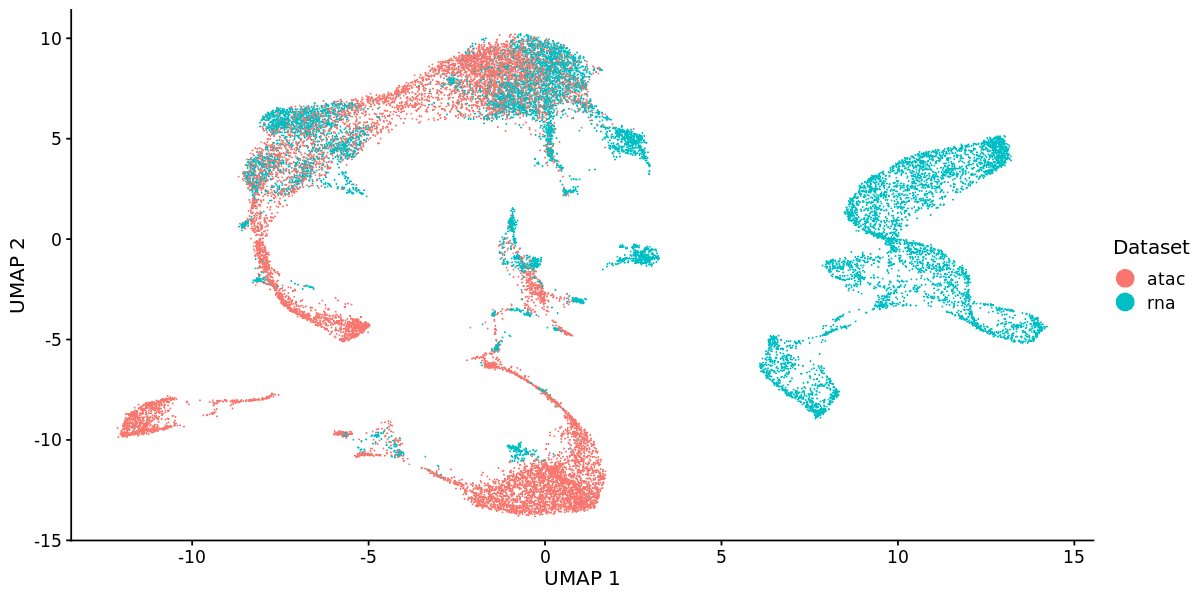

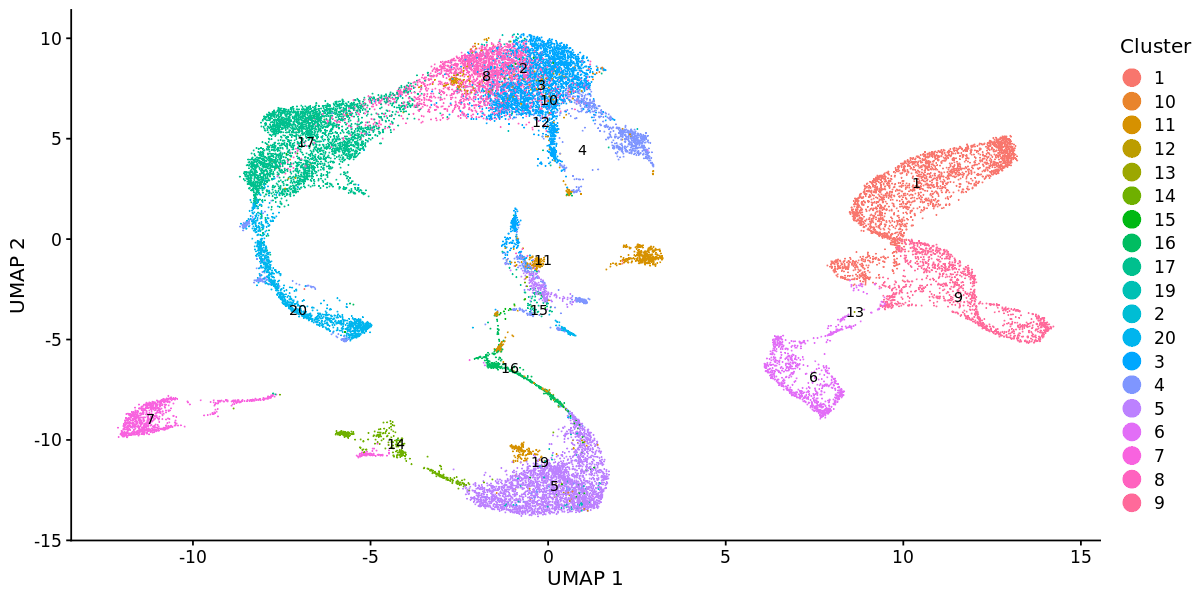

In [11]:
# Default option
options(repr.plot.width = 10, repr.plot.height = 5)
plotByDatasetAndCluster(integrated, axis.labels = c('UMAP 1', 'UMAP 2'))

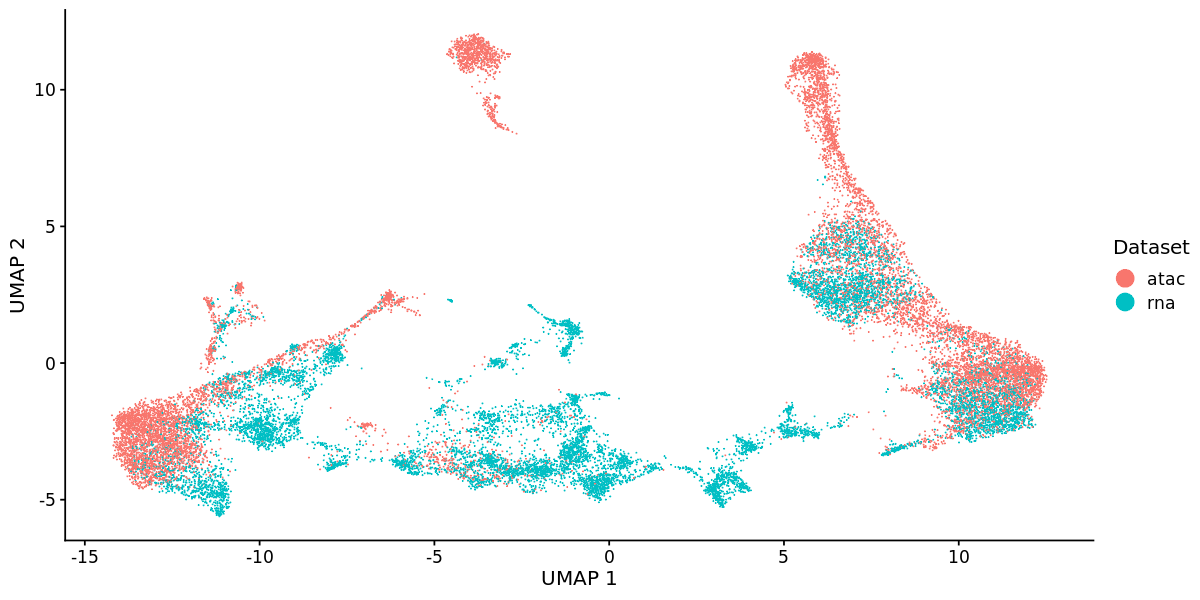

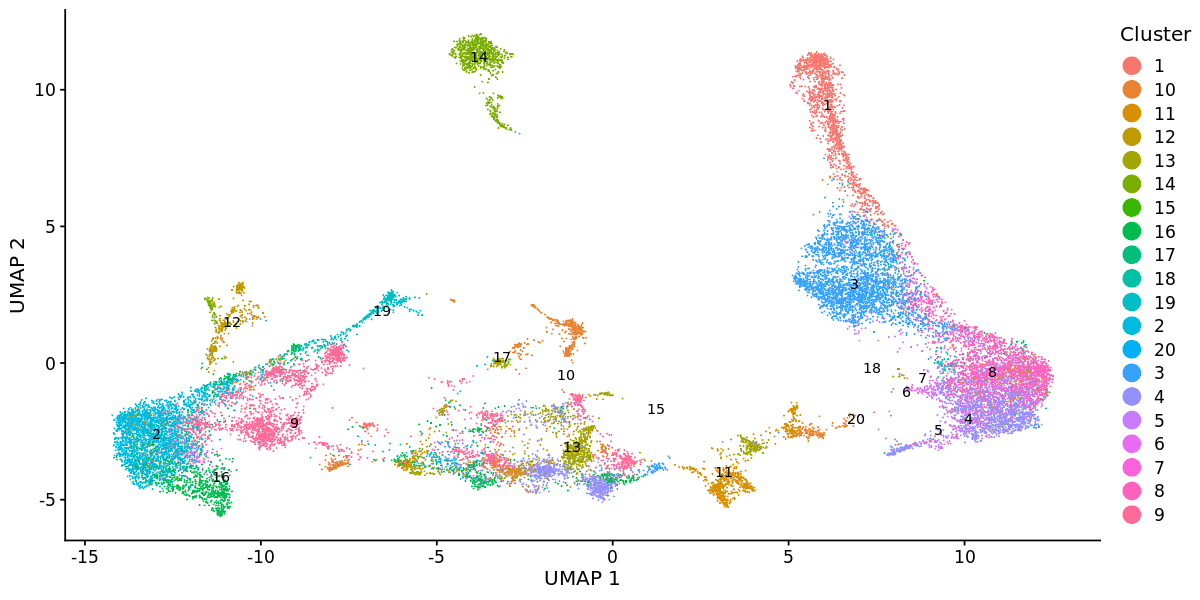

In [134]:
# k = 20, lambda = 15, max.iters = 100
plotByDatasetAndCluster(integrated, axis.labels = c('UMAP 1', 'UMAP 2'))

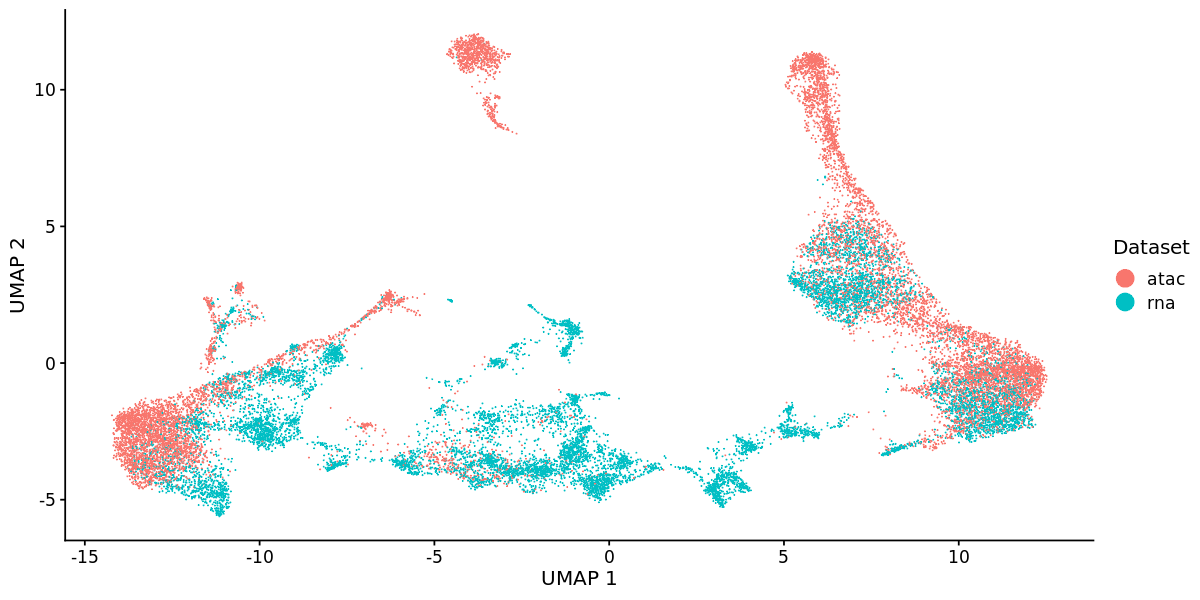

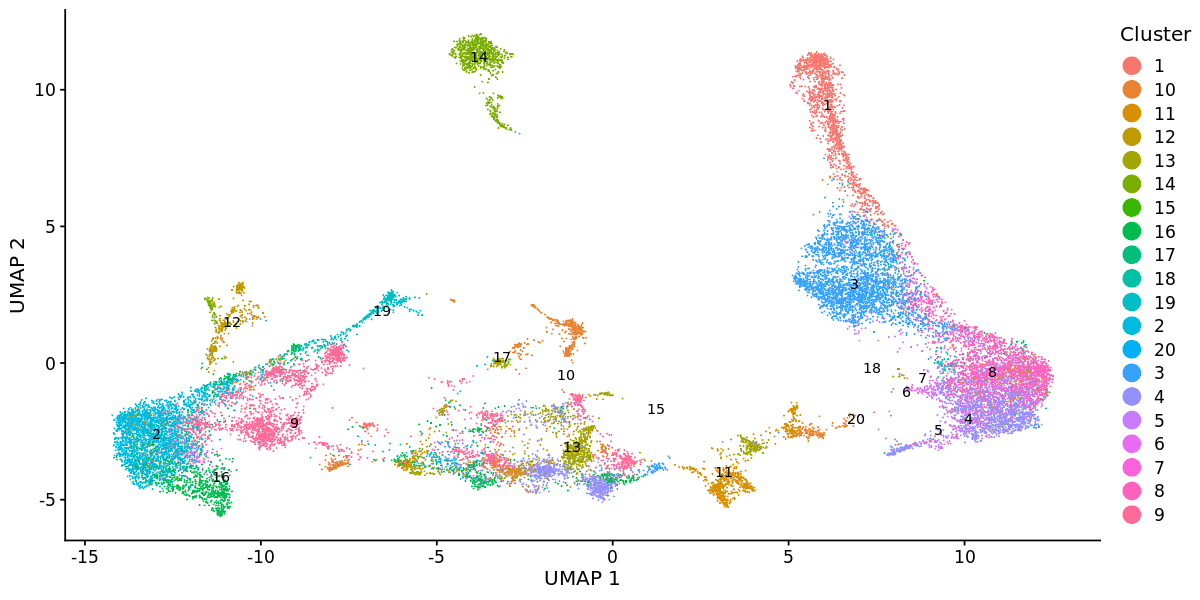

In [134]:
# k = 20, lambda = 15, max.iters = 100, rliger's makeFeatureMatrix
plotByDatasetAndCluster(integrated, axis.labels = c('UMAP 1', 'UMAP 2'))

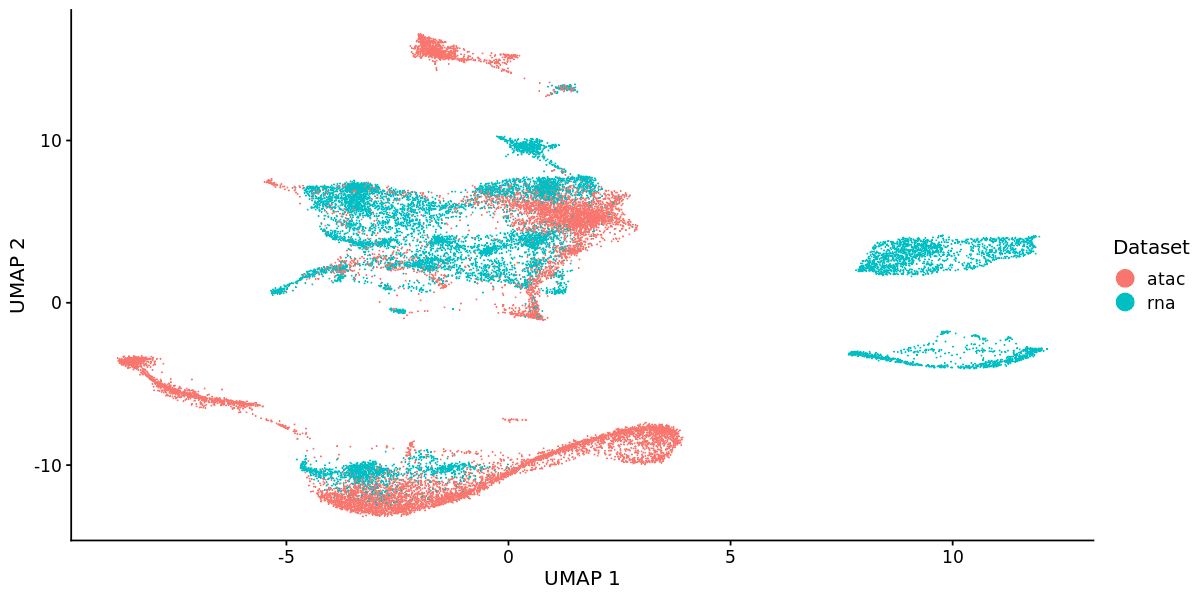

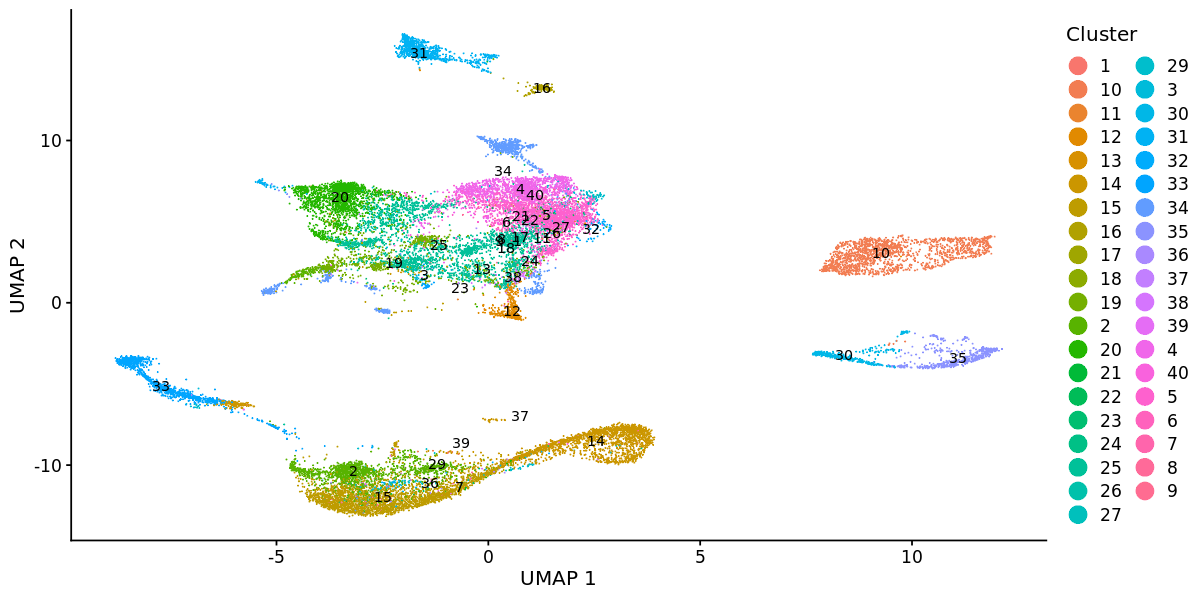

In [152]:
# k = 40, lambda = 15, max.iters = 100, rliger's makeFeatureMatrix
plotByDatasetAndCluster(integrated, axis.labels = c('UMAP 1', 'UMAP 2'))

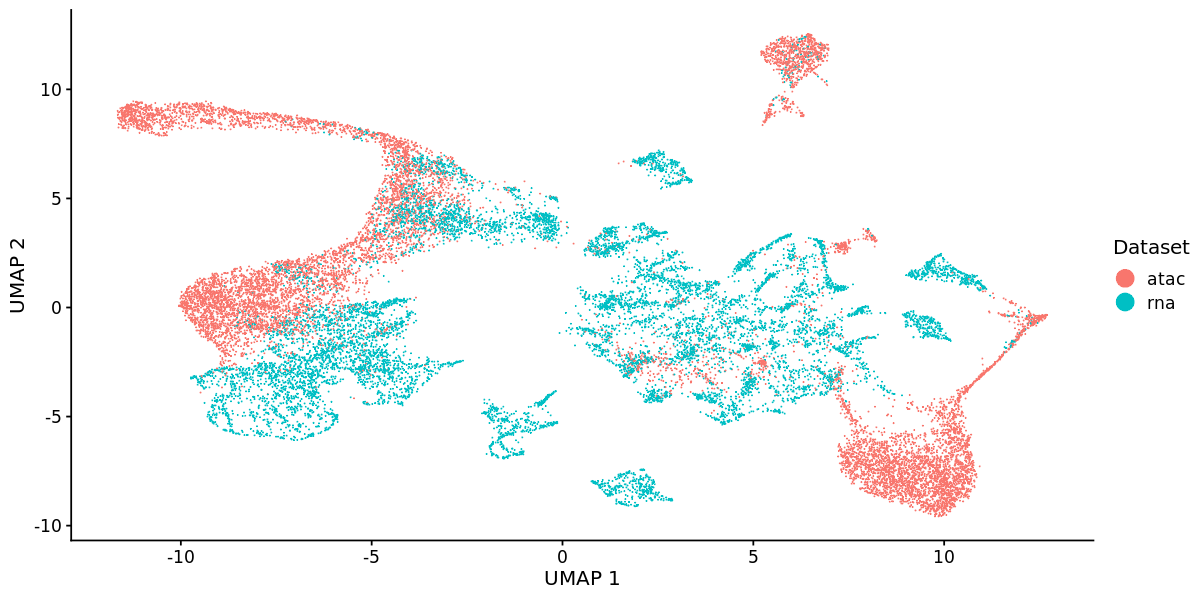

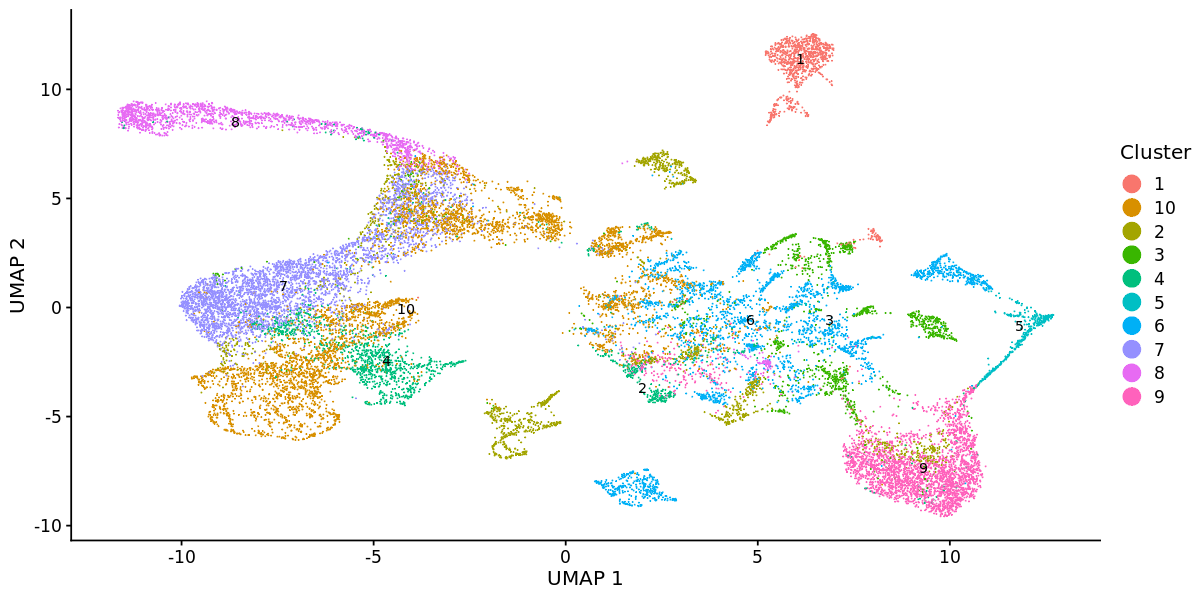

In [157]:
# k = 10, lambda = 15, max.iters = 100, rliger's makeFeatureMatrix
plotByDatasetAndCluster(integrated, axis.labels = c('UMAP 1', 'UMAP 2'))

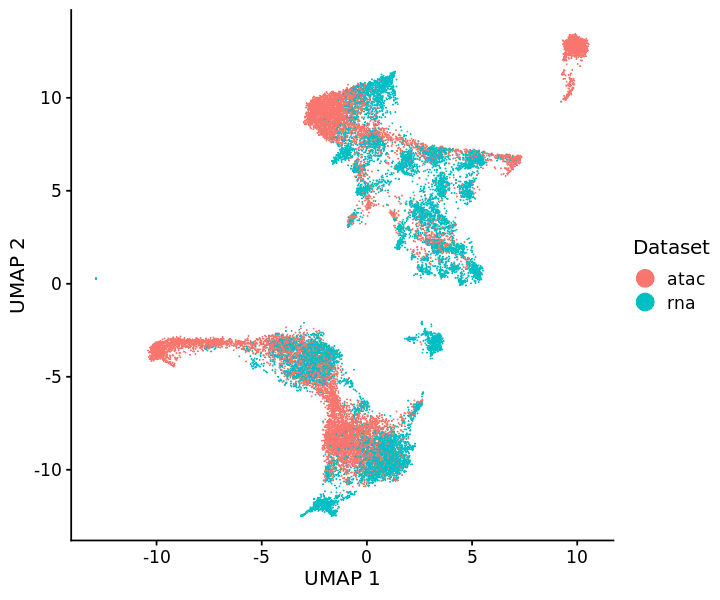

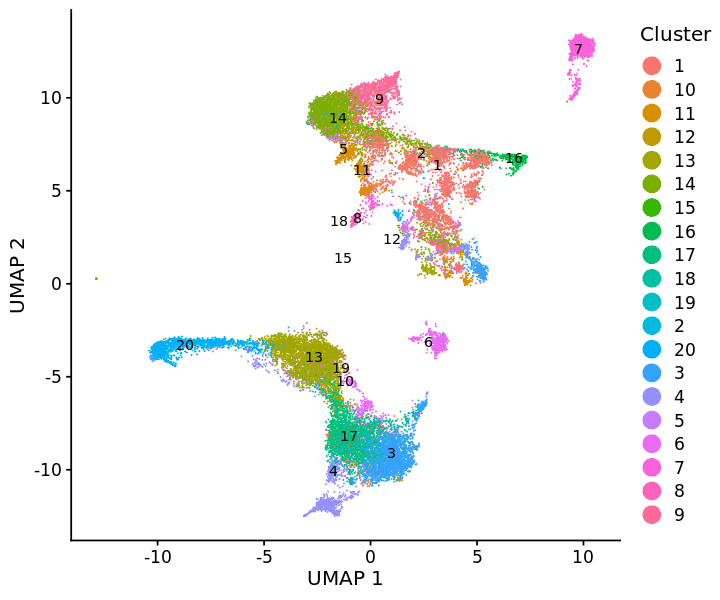

In [42]:
# k = 20, lambda = 30, max.iters = 100, rliger's makeFeatureMatrix
plotByDatasetAndCluster(integrated, axis.labels = c('UMAP 1', 'UMAP 2'))

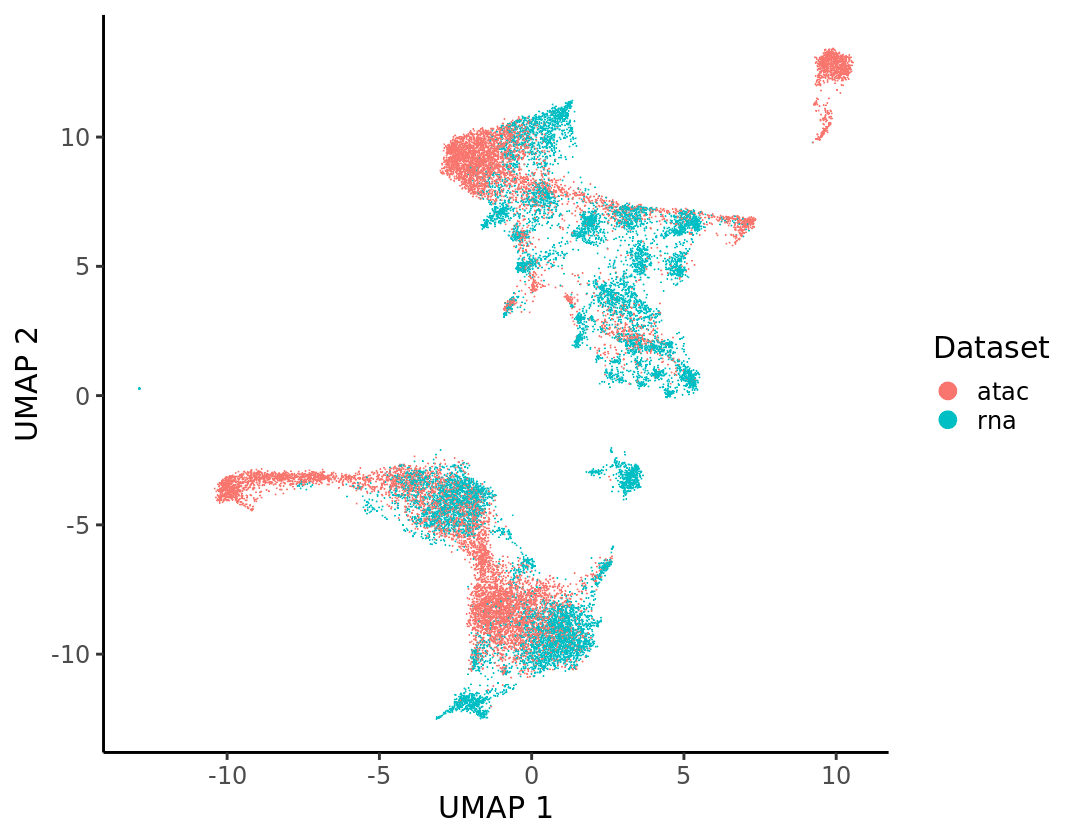

In [43]:
options(repr.plot.width = 9, repr.plot.height = 7)
# k = 20, lambda = 30, max.iters = 100, rliger's makeFeatureMatrix
plot.list = plotByDatasetAndCluster(integrated, axis.labels = c('UMAP 1', 'UMAP 2'), return.plots = T)
plot.list[[1]] + theme_classic(base_size = 18)

In [14]:
meta <- read.table("../../data/pbmc/cell_type.txt", stringsAsFactors = F, head = T)

In [25]:
str(meta)

'data.frame':	11536 obs. of  2 variables:
 $ cluster: int  3 1 2 3 3 2 3 1 6 3 ...
 $ bc     : chr  "AAACAGCCAAGGAATC-1" "AAACAGCCAATCCCTT-1" "AAACAGCCAATGCGCT-1" "AAACAGCCACACTAAT-1" ...


In [44]:
#celltype.df <- data.frame(bc = c(paste0("atac.", meta$bc), paste0("rna.", meta$bc)), celltype = factor(c(meta$cluster, meta$cluster)) )
integrated@cell.data$celltype = celltype.df$celltype[match(rownames(integrated@tsne.coords), celltype.df$bc)]

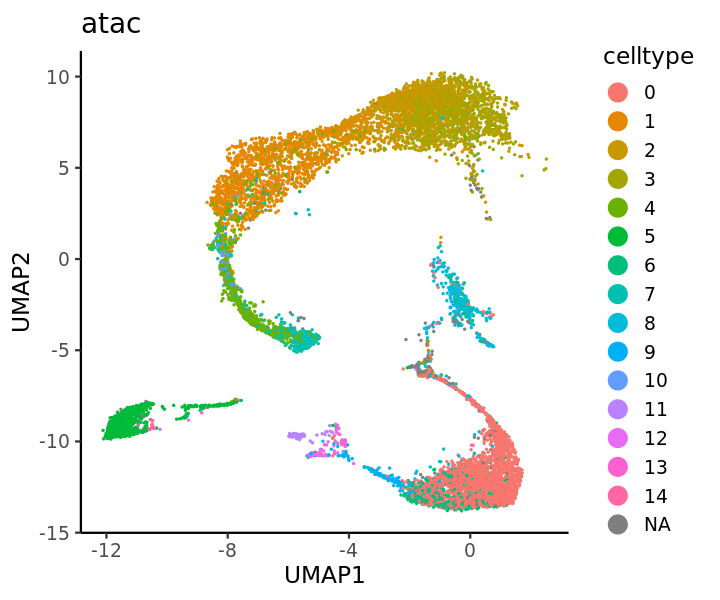

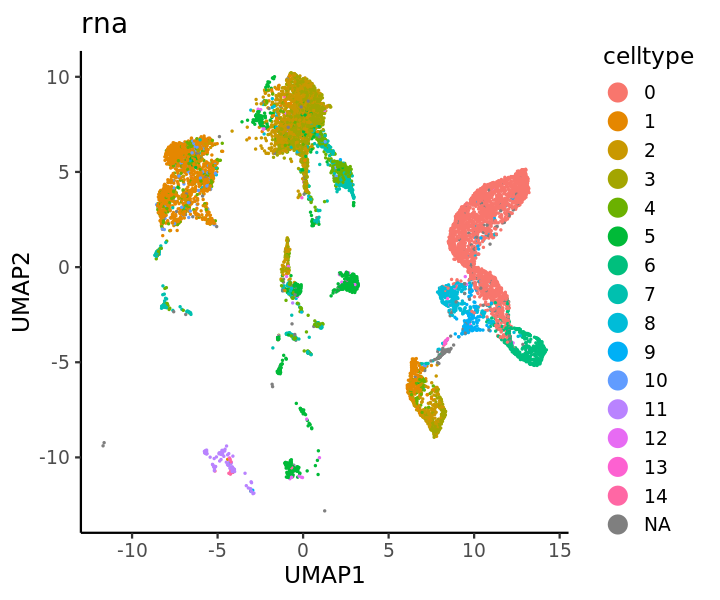

In [35]:
# k = 20, labmda = 5
library(ggplot2)
options(repr.plot.width = 6, repr.plot.height = 5)
plist = plotFeature(integrated, "celltype", return.plots = T)
plist[[1]] + theme_classic(base_size = 14) + xlab("UMAP1") + ylab("UMAP2")
plist[[2]] + theme_classic(base_size = 14) + xlab("UMAP1") + ylab("UMAP2")

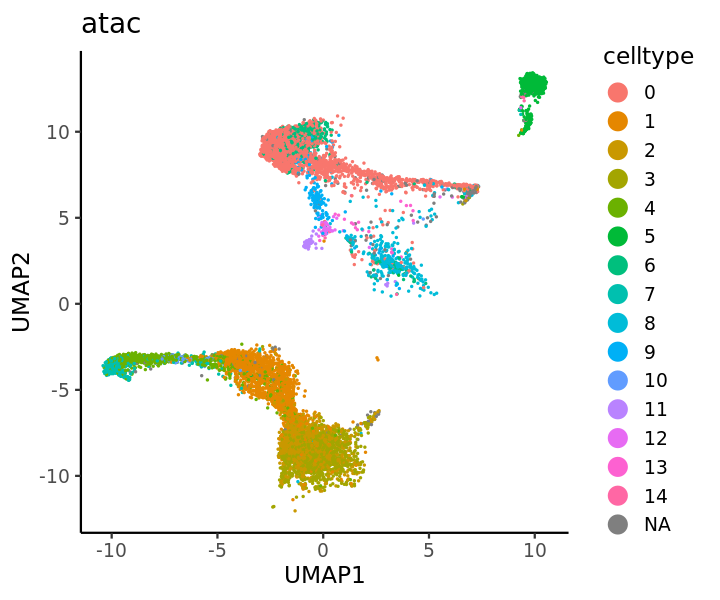

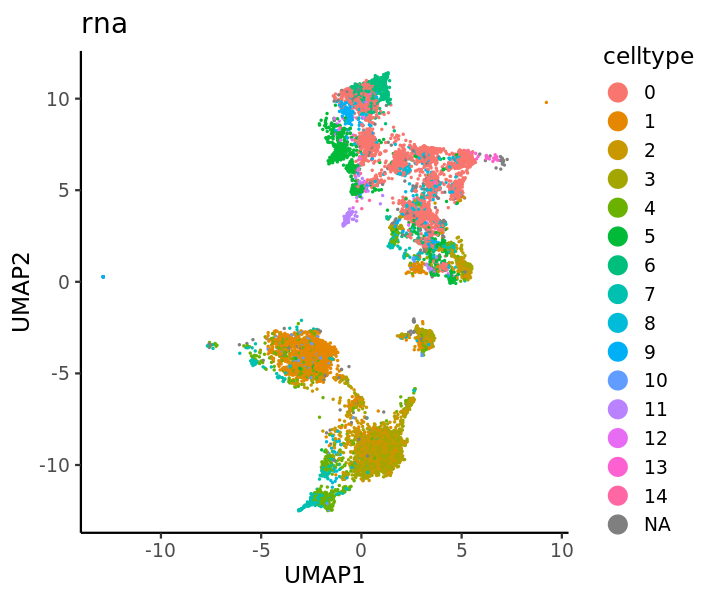

In [45]:
# k = 20, labmda = 30
library(ggplot2)
options(repr.plot.width = 6, repr.plot.height = 5)
plist = plotFeature(integrated, "celltype", return.plots = T)
plist[[1]] + theme_classic(base_size = 14) + xlab("UMAP1") + ylab("UMAP2")
plist[[2]] + theme_classic(base_size = 14) + xlab("UMAP1") + ylab("UMAP2")

In [46]:
integrated_embedding = data.frame(integrated@H.norm)
colnames(integrated_embedding) = paste0("Factor_", 1:ncol(integrated_embedding))
integrated_embedding$cell_type = celltype.df$celltype[match(rownames(integrated_embedding), celltype.df$bc)]


In [47]:
write.table(integrated_embedding, "integrated_embedding.txt", quote = F, sep = "\t", row.names= T, col.names = T)

In [1]:
embedding <- read.table("integrated_embedding.txt")

In [2]:
embedding$batch = as.numeric(factor(sapply(strsplit(rownames(embedding), split = ".", fixed = T), function(s) paste0(s[2:length(s)], collapse = "."))))
str(embedding$batch)

 num [1:21910] 1 2 3 4 5 6 7 8 9 10 ...


In [3]:
write.table(embedding, "integrated_embedding.txt", quote = F, sep = "\t", row.names = T, col.names = T)